In [1]:
import sys
sys.path.append('../../')

In [2]:
import datas.income2023f as income2023f

Loading Data
Finished Loading Data


In [3]:
import sklearn
import numpy as np

In [4]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [5]:
def preprocess(df):
    df = df.copy()
    return_y = False
    if 'income>50K' in df.columns:
        return_y = True
        y = np.array(list(df['income>50K']))
    df.drop(columns=['ID', 'income>50K'], inplace=True, errors='ignore')
    
    ret = [] #np.zeros(shape=[len(df), len(df.columns)], dtype=np.float32)
    
    for i, row in df.iterrows():
        dp = [
            row.age,
            *row.workclass,
            row.fnlwgt,
            *row.education,
            row['education.num'],
            *row['marital.status'],
            *row.occupation,
            *row.relationship,
            *row.race,
            *row.sex,
            row['capital.gain'],
            row['capital.loss'],
            row['hours.per.week'],
            *row['native.country']
        ]
        # dp.extend(np.multiply(dp, dp))
        # dp.extend(np.cos(dp))
        ret.append(dp)
    
    if return_y:
        return np.array(ret), y
    return np.array(ret)

In [6]:
train, train_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_training_partition])
validation, validation_y = preprocess(income2023f.train_preprocessed.iloc[income2023f.train_valdiation_partition])

In [7]:
# C_range = np.logspace(-2, 10, 3)
# gamma_range = np.logspace(-9, 3, 3)
# param_grid = dict(gamma=gamma_range, C=C_range)
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
svc = make_pipeline(
    StandardScaler(),
    SVC(random_state=42)
)
# grid = GridSearchCV(svc, param_grid=param_grid, cv=cv)

In [8]:
train_y.shape

(20000,)

In [9]:
# grid.fit(train, train_y)
# print(
#     "The best parameters are %s with a score of %0.2f"
#     % (grid.best_params_, grid.best_score_)
# )
svc.fit(train, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=42))])

In [10]:
validation_pred = svc.decision_function(validation)

In [11]:
validation_y.shape, validation_pred.shape

((5000,), (5000,))

In [12]:
import scikitplot as skplt

<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

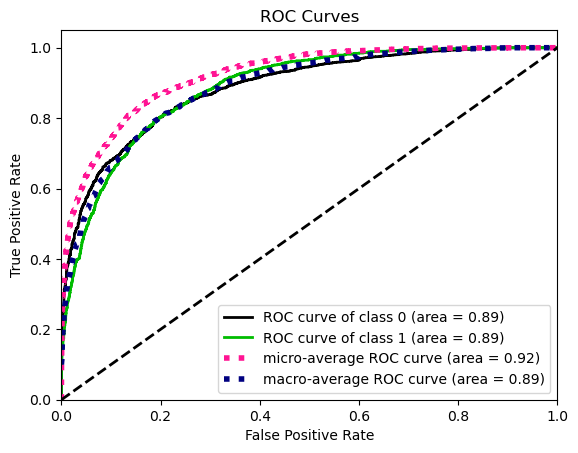

In [13]:
skplt.metrics.plot_roc(
    validation_y,
    np.array([
        1-validation_pred,
        validation_pred
    ]).T
)

In [14]:
test = preprocess(income2023f.test_preprocessed)
test_pred = svc.decision_function(test)

In [15]:
import pandas as pd
pd.DataFrame(
    {
        'ID': list(range(1, 23843)),
        'Prediction':test_pred
    }
).to_csv('./svm_test_predictions.csv', index=False)

# Save out prediction on training set to use as a feature in another SVM

In [16]:
full_train, full_train_y = preprocess(income2023f.train_preprocessed)

In [17]:
full_train_pred = svc.decision_function(full_train)

In [20]:
pd.DataFrame(
    {'full_train_pred':full_train_pred}
).to_csv('./svm_full_train_predictions.csv', index=False)